<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/main/benin_apache_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is based on the tutorial for [land cover classification.](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV) and [weather forcasting](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/weather-forecasting).

Our current objective is to prepare a dataset of Benin which will be used to train a model to predict which pixels belong to a village. We wish to take in the feature collection from 'projects/satellite-cnns/assets/benin/voronoi_villages' which has circles around villages in Benin and use this as a target for prediction. As input, we wish to use landsat 7 imagery of Benin.

The notebook has the sections:


1.   Setup
2.   Pull defined functions for dataset creation and sampling
3.   Create pipeline and do data export
4. Read data

Sections 1-2 closely follow the tutorial notebook and appear to be working. Section 3 has been updated to follow the weather forcasting sample by using compressed NumPy files instead of TFrecord files.

dd: **Moved change notes to [CHANGELOG.md](CHANGELOG.md)**

rb: **Need to update changelog and clean data.py a little, LS C2 composite works now**




# Setup

In [1]:
%rm -r /content/satellite_cnns
%cd /content

rm: cannot remove '/content/satellite_cnns': No such file or directory
/content


In [2]:
branch = "main"

In [3]:
# Clone from SPIRES Repo
!git clone --branch {branch} https://github.com/Sanford-Lab/satellite_cnns.git
%cd /content/satellite_cnns

Cloning into 'satellite_cnns'...
remote: Enumerating objects: 806, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 806 (delta 67), reused 24 (delta 12), pack-reused 561 (from 1)
Receiving objects: 100% (806/806), 4.95 MiB | 6.69 MiB/s, done.
Resolving deltas: 100% (420/420), done.
/content/satellite_cnns


**New**: The notebook now sources files from the Sanford-Lab/satellite_cnns repo. For this notebook, it will use the `benin-data` package. It's built it based on the weather-forcasting notebook patterns and to allow importing for project-specific packages to *plug and play* for data creation. The new patterns should allow the workflow to be much more modular. All a new project would need to do is define 3 main functions `get_inputs_image`, `get_labels_image`, and `sample_points`. The create_dataset.py script should then be able to synthesize the dataset through abstraction. I've kept most of the demonstration functionality the same to show how using the package works.

In [4]:
!pip install --quiet --upgrade pip

# We need `build` and `virtualenv` to build the local packages.
!pip install --quiet build virtualenv

# Install Apache Beam and the `benin-data` local package.
!pip install apache-beam[gcp] src/benin-data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 51.2 MB/s eta 0:00:00
Processing ./src/benin-data
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 123.8 MB/s eta 0:00:00
  Created wheel for benin-data: filename=benin_data-1.1.0-py3-none-any.whl size=4814 sha256=e7e009f27441744d237a2e743acc6ff5d

In [5]:
# run to manually restart runtime by ending process
# exit()

At this point runtime is restarted. Navigate back to our working directory.

In [1]:
%cd /content/satellite_cnns

/content/satellite_cnns


In [2]:
#@title Project settings
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "satellite-cnns" #@param {type:"string"}
bucket = "beninbucket" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith('gs://'), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [8]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

# Define functions for dataset creation

This section generally follows the tutorial notebook. In the end, we wish for the inputs to be LANDSAT 7 data of Benin. We select R, G, B, and NDVI bands for the input data. As labels, we wish to prepare a binary image with a target label of 1 if pixel belongs to a village and a 0 if it does not belong to a village. The village circles are specified in a feature collection available at: 'projects/satellite-cnns/assets/voronoi_villages'

Based on our visulizations with folium at the end, this section appears to be working fine.

**dd_NEW**: To utilize the new package data, I replaced the function definitions in the notebook with their imports from the package. You can see the function declarations here:

> <button>
>
> [![Open in GitHub](https://www.tensorflow.org/images/GitHub-Mark-32px.png) `benin/data.py`](src/benin-data/benin/data.py)
> </button>

In this next code chunk, we prepare the inputs and label images.

In [3]:
from benin.data import get_inputs_image

In [4]:
from benin.data import get_labels_image

## Visualize the input and target

In [5]:
#Visualize the target. White circles are inside villages, black circles are outside villages
# RB did it always look like this? White with the rest all black or is the viz messed up?
import folium

mapid = get_labels_image().getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[9.8, 2.4], zoom_start = 7)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [6]:
# view the first three bands of the features
image = get_inputs_image()
# RB edited this too to make bands visible with new LS C2 data
vis_params = {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 0.3, 'gamma': 1.4}

folium.Map(
    location=(9.8, 2.4),
    zoom_start=7,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [7]:
bands = image.bandNames().getInfo()
print(f"Number of bands:{len(bands)}\nBands:")
for b in bands: print(f"{b}\t", end='')

Number of bands:5
Bands:
R	G	B	NIR	NDVI	

# Define functions for sampling points

The main functions: sample_points, get_patch, get_input_patch, get_label_patch, and get_training_example are all taken from the tutorial. For our data we have the classes "in village" and "not in village", and we perform stratified sampling in these villages. Based on our visualization at the end, this section appears to be working.

** dd_NEW ** Again, import the data package to use the benin-specific functions.

In [8]:
from benin import data

for point in data.sample_points():
  print(point)

[2.474858607749282, 12.03293323078099]
[1.899936825912788, 7.325761141994698]
[2.241296633878206, 11.197500016549837]
[2.5826564418436244, 6.948468722664499]


To access the create_dataset script, we're going to enter the repo:

In [9]:
from create_dataset import get_training_example

point = [1.9046529811544155, 6.937464360434035]
target = data.get_labels_image(as_double=True)
(inputs, labels) = get_training_example(point, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")

inputs : float64 (128, 128, 5)
labels : float64 (128, 128, 1)


## Visualize a sampled patch

We can visualize how our `sample_points` and `get_training_example` functions work using the `show_patch` function from our `visualize.py` module.

The following code block shows how how `sample_points` generates two points inside and outside villages based on sampling params. RED is inside, BLUE is outside a village. Change the seed to get different sample points.

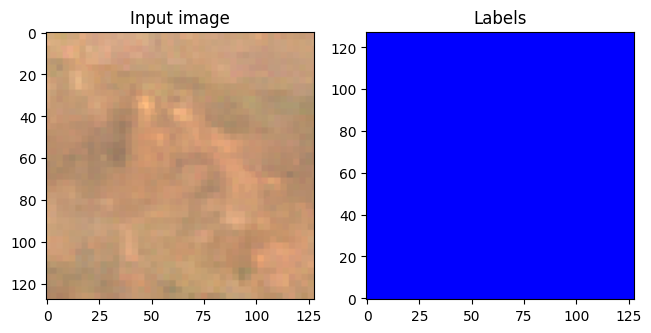

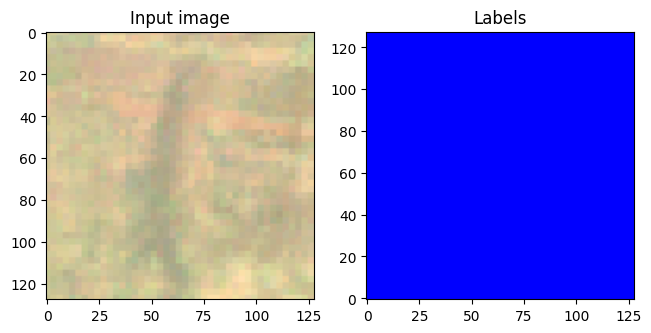

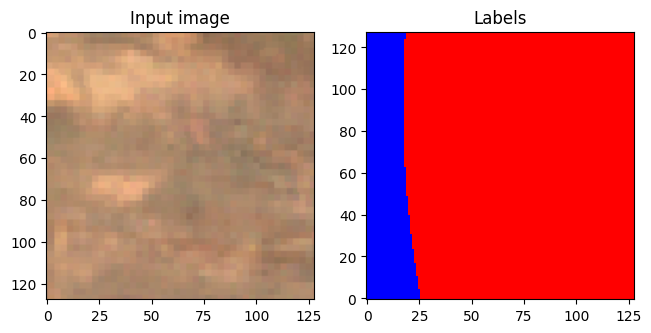

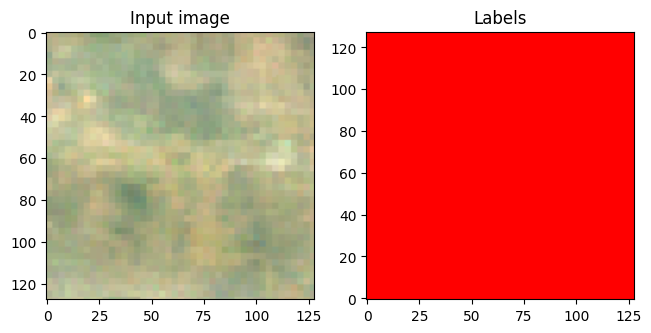

In [10]:
from create_dataset import get_training_example
from visualize import show_patch

SEED = 0

# Print input and labels for sampling of 2 points per class
# (two points )
for point in data.sample_points(seed=SEED,points_per_class=2):
  (inputs, labels) = get_training_example(point, patch_size = 128)
  show_patch(inputs, labels)

In [11]:
print(f'Image has dtype {inputs.dtype}')
print(f'Labels has dtype {labels.dtype}')

Image has dtype float64
Labels has dtype float64


# Create pipeline and do data export

Next we use an Apache-Beam pipeline to create and upload the training examples through
can create the NPZ files locally or through the distributed Dataflow runner.

## Define necessary functions for export

In [12]:
PATCH_SIZE = 128
MAX_REQUESTS = 20
POINTS_PER_CLASS = 10 # small for testing purposes

## Run the pipeline locally

In [13]:
data_path = "data/"

In [14]:
#!pip install --quiet apache-beam[interactive]

In [15]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from benin.data import sample_points
from create_dataset import write_npz

beam_options = PipelineOptions([], direct_num_workers=1)
SEED = 0

with beam.Pipeline(options=beam_options) as pipeline:
  (
      pipeline
      | "🌱 Make seeds" >> beam.Create([0])
      | "📌 Sample points" >> beam.FlatMap(sample_points, points_per_class=POINTS_PER_CLASS)
      | "🃏 Reshuffle" >> beam.Reshuffle()
      | "🛰 Get examples" >> beam.Map(get_training_example, patch_size=PATCH_SIZE)
      | "🗂️ Batch examples" >> beam.BatchElements()
      | "📝 Write NPZ files" >> beam.Map(write_npz, data_path)
  )

View created files

In [16]:
!ls -lh data

total 1.2M
-rw-r--r-- 1 root root  56K Aug 22 09:21 0b73b451-15c1-4cf9-b0a1-53dcea7da35a.npz
-rw-r--r-- 1 root root 118K Aug 22 09:20 1b0d5d84-0ba1-463e-8ae7-6244d1c92ea7.npz
-rw-r--r-- 1 root root 107K Aug 22 09:18 2d963c64-8eeb-4573-8cd1-20e3f98d4736.npz
-rw-r--r-- 1 root root  57K Aug 22 09:19 46473253-5353-4f81-814e-16b96058a9fb.npz
-rw-r--r-- 1 root root  56K Aug 22 09:18 5817575b-f733-40bd-9e0b-44a2ab9d05f9.npz
-rw-r--r-- 1 root root 116K Aug 22 09:21 5e8d1ce2-5831-46de-b6a5-2ec834434486.npz
-rw-r--r-- 1 root root  54K Aug 22 09:17 65ae1cb7-66e4-4685-ae3e-7d01a3e144ac.npz
-rw-r--r-- 1 root root  57K Aug 22 09:19 8fef817e-c2bc-4786-93d3-2b3470ac2a0b.npz
-rw-r--r-- 1 root root 122K Aug 22 09:19 95d0dbcb-91c5-4230-b239-df18b68427e4.npz
-rw-r--r-- 1 root root  57K Aug 22 09:17 9a3d79ee-b76e-42ad-bde1-8cbed4bd9d06.npz
-rw-r--r-- 1 root root  57K Aug 22 09:20 ad7d3969-8c50-4952-b248-0075a6170dad.npz
-rw-r--r-- 1 root root 114K Aug 22 09:21 b841a2f4-8351-4fb6-8256-064cf64ff1f9.npz
-rw-r

In [17]:
%rm -r data/

## Use the Distributed runner

To have a remote distributed runner complete the pipeline task, we created a script, `create_dataset.py` that will `run()` our pipeline based on arguments we can adjust. To do that, it needs acceess to the data package used, so we have to build it to give to Dataflow:

In [27]:
# build benin data package to send to distributed runner
!python -m build src/benin-data

* Creating isolated environment: venv+pip...
* Installing packages in isolated environment:
  - setuptools >= 40.8.0
* Getting build dependencies for sdist...
running egg_info
writing benin_data.egg-info/PKG-INFO
writing dependency_links to benin_data.egg-info/dependency_links.txt
writing requirements to benin_data.egg-info/requires.txt
writing top-level names to benin_data.egg-info/top_level.txt
reading manifest file 'benin_data.egg-info/SOURCES.txt'
writing manifest file 'benin_data.egg-info/SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing benin_data.egg-info/PKG-INFO
writing dependency_links to benin_data.egg-info/dependency_links.txt
writing requirements to benin_data.egg-info/requires.txt
writing top-level names to benin_data.egg-info/top_level.txt
reading manifest file 'benin_data.egg-info/SOURCES.txt'
writing manifest file 'benin_data.egg-info/SOURCES.txt'

running check
creating benin_data-1.1.0
creating benin_data-1.1.0/benin
creating benin_data-1.1.0/be

See the benin-data package

In [28]:
!ls -lh src/benin-data/dist

total 16K
-rw-r--r-- 1 root root 4.8K Aug 22 09:29 benin_data-1.1.0-py3-none-any.whl
-rw-r--r-- 1 root root 4.4K Aug 22 09:29 benin_data-1.1.0.tar.gz


Define the GC data path for the exported files:

In [29]:
folder = 'dd_test'
data_path=f"gs://{bucket}/{folder}"
print(f'{data_path}')

gs://benin-bucket1/dd_test


Run the distributed runner (Dataflow):

In [30]:
!python create_dataset.py \
  --data-path="{data_path}/data" \
  --ppc="{POINTS_PER_CLASS}" \
  --runner="DataflowRunner" \
  --num-workers="5"\
  --project="{project}" \
  --region="{location}" \
  --temp_location="{data_path}/temp" \
  --extra_package="./src/benin-data/dist/benin_data-1.1.0.tar.gz" \
  --network="default"

INFO:google.auth.compute_engine._metadata:Compute Engine Metadata server call to universe/universe_domain returned 404, reason: 
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "tuple"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[tuple[np.ndarray, np.ndarray]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "str"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "str"
INFO:apache_beam.runners.dataflow.dataflow_runner:Pipeline has additional dependencies to be installed in SDK worker container, consider using the SDK container image pre-building workflow to avoid repetitive installations. Learn more on https://cloud.google.com/dataflow/docs/guides/using-custom-containers#prebuild
INFO:root:Using provided Python SDK container image: gcr.io/cloud-dataflow/v1beta3/beam_python3.10_sdk:2.58.

In [22]:
!gsutil ls -lh {data_path}/data

112.32 KiB  2024-07-25T20:29:04Z  gs://beninbucket/dd_test/data/02e34c34-9859-4b24-a59d-538bc0d23c10.npz
212.06 KiB  2024-08-22T08:12:37Z  gs://beninbucket/dd_test/data/22ebaffb-fa33-4065-aed0-eb8b73d2d39b.npz
 59.75 KiB  2024-08-22T08:13:49Z  gs://beninbucket/dd_test/data/2493fc58-282b-413c-97b8-0e522cb5964b.npz
111.94 KiB  2024-07-25T20:32:25Z  gs://beninbucket/dd_test/data/283b1cb7-decd-4de7-b8ec-9133fdec8407.npz
118.75 KiB  2024-08-22T08:11:39Z  gs://beninbucket/dd_test/data/403bdc6b-6bbd-4365-87c3-947dc247d23b.npz
 56.27 KiB  2024-07-25T20:33:15Z  gs://beninbucket/dd_test/data/41f9732c-5e75-46fe-a11b-2784df7e3505.npz
 55.09 KiB  2024-07-25T20:31:55Z  gs://beninbucket/dd_test/data/4aa32140-8951-4de9-908f-8b5570c81114.npz
 56.24 KiB  2024-08-22T08:14:13Z  gs://beninbucket/dd_test/data/54ae62ae-692d-4cab-a12a-3a5605e93587.npz
 55.31 KiB  2024-08-22T08:14:50Z  gs://beninbucket/dd_test/data/5d9e4bb5-71ee-40c6-a8ec-a3e89bcc63f3.npz
337.46 KiB  2024-07-25T20:31:33Z  gs://beninbucket/dd_t

# Read data


Let's check Google Cloud Storage to see the files in GC

In [32]:
bucket = 'beninbucket'
folder = 'dd_test'
data_path=f"gs://{bucket}/{folder}/data"
print(data_path)
!gsutil ls -lh {data_path}

gs://beninbucket/dd_test/data
112.32 KiB  2024-07-25T20:29:04Z  gs://beninbucket/dd_test/data/02e34c34-9859-4b24-a59d-538bc0d23c10.npz
212.06 KiB  2024-08-22T08:12:37Z  gs://beninbucket/dd_test/data/22ebaffb-fa33-4065-aed0-eb8b73d2d39b.npz
 59.75 KiB  2024-08-22T08:13:49Z  gs://beninbucket/dd_test/data/2493fc58-282b-413c-97b8-0e522cb5964b.npz
111.94 KiB  2024-07-25T20:32:25Z  gs://beninbucket/dd_test/data/283b1cb7-decd-4de7-b8ec-9133fdec8407.npz
118.75 KiB  2024-08-22T08:11:39Z  gs://beninbucket/dd_test/data/403bdc6b-6bbd-4365-87c3-947dc247d23b.npz
 56.27 KiB  2024-07-25T20:33:15Z  gs://beninbucket/dd_test/data/41f9732c-5e75-46fe-a11b-2784df7e3505.npz
 55.09 KiB  2024-07-25T20:31:55Z  gs://beninbucket/dd_test/data/4aa32140-8951-4de9-908f-8b5570c81114.npz
 56.24 KiB  2024-08-22T08:14:13Z  gs://beninbucket/dd_test/data/54ae62ae-692d-4cab-a12a-3a5605e93587.npz
 55.31 KiB  2024-08-22T08:14:50Z  gs://beninbucket/dd_test/data/5d9e4bb5-71ee-40c6-a8ec-a3e89bcc63f3.npz
337.46 KiB  2024-07-25T20

Next, let's copy the files to a local directory to look at them

In [24]:
!mkdir -p data-training
!gsutil -m cp {data_path}/* data-training

Copying gs://benin-bucket1/dd_test/data/05c97fa8-9c14-4eef-ab6b-0e75c29f257c.npz...
Copying gs://benin-bucket1/dd_test/data/0505d488-608c-4b5a-86d6-fef5a9e8da4c.npz...
Copying gs://benin-bucket1/dd_test/data/0ae3738f-54b5-4f0c-a8ac-330ffd87a1d5.npz...
Copying gs://benin-bucket1/dd_test/data/1e59ccb5-2600-4a2a-b92a-61ec85aa2810.npz...
Copying gs://benin-bucket1/dd_test/data/0ed5cad9-3d7a-4e9f-aa9b-b193ff40ff02.npz...
Copying gs://benin-bucket1/dd_test/data/1840402b-067e-4541-a722-a13d46f8413d.npz...
Copying gs://benin-bucket1/dd_test/data/22646593-bcfe-44a6-8b63-4d045f0bf26e.npz...
Copying gs://benin-bucket1/dd_test/data/1f27aca0-845d-4ed5-994a-a764f0631c36.npz...
Copying gs://benin-bucket1/dd_test/data/207ed774-9eed-46f6-adc5-d1cb7a558d28.npz...
Copying gs://benin-bucket1/dd_test/data/2679089e-bde0-4fbc-b79c-f0c936caeed6.npz...
Copying gs://benin-bucket1/dd_test/data/3965de64-c362-49b0-8996-54e1958d305d.npz...
Copying gs://benin-bucket1/dd_test/data/3d6b2ac5-e789-47b0-bd55-e78ace9e5888

In [25]:
# Use this to wipe the folder if needed
#%rm -r data-training

# Look at dataset

In [26]:
import torch
from read_data import DatasetFromPath, test_train_split

dataset = DatasetFromPath('data-training')

ImportError: cannot import name '_accumulate' from 'torch._utils' (/usr/local/lib/python3.10/dist-packages/torch/_utils.py)

**Note**: to avoid using [Hugging Face 🤗 Datasets](https://huggingface.co/docs/datasets/main/en/index) (like in the weather forcasting sample), we're going to use a custom subclass of PyTorch's `torch.utils.data.Dataset` (`DatsetFromPath`). Hugging Face is nice to use a high-level interface for using datasets and should maybe be implemented in the future, but as of this writing (7/4/2023), VertexAI (what we're using for cloud training) has an issue with it's Hugging Face Trainer API (see [weather sample issue](https://github.com/GoogleCloudPlatform/python-docs-samples/issues/9272)).

### Visualize

Let's grab the dataset (`data`) from our path (`/content/data_training`) and pull the top element from the dataset as `example`. In `DatasetFromPath`, the custom getter utilizes dictionary keys of `inputs` and `labels`, so to grab the inputs of example, we use `example['inputs']`.

Check what was run through the pipeline. You should expect to see:
- Dataset size of 2 * `POINTS_PER_CLASS` or 4 if `POINTS_PER_CLASS` was not declared/put into the pipeline.
- inputs size of (`PATCH_SIZE`, `PATCH_SIZE`, number of input bands)
- labels size of (`PATCH_SIZE`, `aPATCH_SIZE`, number of label bands)

Note: For Benin, there are 4 input bands and 1 label band.

In [ ]:
print(f"Dataset size: {len(dataset)}")
example = dataset[0]  # random access the first element

print(f"inputs: {example['inputs'].shape}")
print(f"labels: {example['labels'].shape}")

The `DatsetFromPath` class also allows you to retrieve all of the inputs/labels in a dataset in their raw NumPy array form by indexing with "inputs" or "labels":

In [ ]:
inputs = dataset['inputs']
labels = dataset['labels']

print(f"All inputs: {inputs.shape}")
print(f"All labels: {labels.shape}")

Let's view our example using our visualization functionality. For Benin, blue = inside village, red = outside village.

In [ ]:
from visualize import show_patch


inputs = example['inputs']
labels = example['labels']

show_patch(inputs, labels)

How let's split the dataset into a train and test subset using the test_train_split function. Test differt ratios to see how the dataset splits and view the first of each.

In [ ]:
ratio = 0.5
train, test = test_train_split(dataset, ratio=0.5, seed=0)

print(f"Train size: {len(train)}")
train_example = train[0]  # random access the first element
print(f"inputs: {train_example['inputs'].shape}")
print(f"labels: {train_example['labels'].shape}")
print(f"Test size: {len(train)}")
test_example = test[0]  # random access the first element
print(f"inputs: {test_example['inputs'].shape}")
print(f"labels: {test_example['labels'].shape}\n")

train_inputs = train_example['inputs']
train_labels = train_example['labels']
test_inputs = test_example['inputs']
test_labels = test_example['labels']
print(f'Train[0]:')
show_patch(train_inputs, train_labels)
print(f'Test[0]:')
show_patch(test_inputs, test_labels)

### Test access: Statistics

I'm just testing to make sure we can access the data in the way we want... haven't checked for proper use of np.mean().

In [ ]:
from torch.utils.data.dataloader import DataLoader
# future
import numpy as np

print(type(dataset['inputs']))
print(train['inputs'].shape)
data = train['inputs']
mean = data.mean(axis=(0, 1, 2))[None, None, None, :]
std = data.std(axis=(0, 1, 2))[None, None, None, :]

print(f'Train inputs mean: {mean.shape}')
print(f'Train inputs std: {std.shape}')

# Model

1.   **Define the model**: An UNTESTED implementation of U-Net has been placed in [model.py](src/benin-model/benin/model.py). Check it for the model specifications.
2.   **Train** (locally or with VertexAI)




We're going to use the custom package `benin-model` that contains:

*   **npz_dataset.py**: module library for reading a directory with
*   **model.py**: model specifications (currently has a U-Net model)
*   **train.py**: script that uses other modules to create, train, and save a model
*   **dice_score.py**: holds a few dice score helper functions for training


In addition, we need the Google Cloud AI Platform API to send a training job to VertexAI.

In [ ]:
!pip install google-cloud-aiplatform src/benin-model

Processing ./src/benin-model
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for benin-model: filename=benin_model-0.2.2-py3-none-any.whl size=10034 sha256=5be1f99032af487fb9ff36ff256d00ca71152326cd36b422a3edac54fc15d9d6
  Stored in directory: /root/.cache/pip/wheels/43/06/1d/1bbd32645d1f8a5a93a4774650685f7b4c75ff4e91adee8b12
Successfully built benin-model
  Attempting uninstall: benin-model
    Found existing installation: benin-model 0.2.1
    Uninstalling benin-model-0.2.1:
      Successfully uninstalled benin-model-0.2.1


# Train locally

Run 'Read data' cells or change data_path to directory with .npz files.


*   `data_path`: directory with npz files
*   `model_path`: model path / model name prefix



In [ ]:
from benin.train import run_torch
run_torch(
    data_path = 'data-training',
    model_path = 'test-model',
    epochs=1
)

data_path: data-training
model_path: test-model
epochs: 1
batch_size: 512
train_test_ratio: 0.66
----------------------------------------
Dataset from 'data-training', size: 20, inputs: (20, 128, 128, 4), labels: (20, 128, 128, 1)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Check to see if your model was created:

In [ ]:
!ls /content/satellite_cnns

archived_notebooks	     create_dataset.py	README.md	 visualize.py
benin_apache_pipeline.ipynb  data-training	src
CHANGELOG.md		     read_data.py	test-model_UNET


# Train w/ VertexAI

Again, we have to build our package to send to be used by VertexAI:

In [ ]:
# Build the `weather-model` package.
!python -m build src/benin-model

* Creating virtualenv isolated environment...
* Installing packages in isolated environment... (setuptools >= 40.8.0, wheel)
* Getting build dependencies for sdist...
running egg_info
writing benin_model.egg-info/PKG-INFO
writing dependency_links to benin_model.egg-info/dependency_links.txt
writing entry points to benin_model.egg-info/entry_points.txt
writing requirements to benin_model.egg-info/requires.txt
writing top-level names to benin_model.egg-info/top_level.txt
reading manifest file 'benin_model.egg-info/SOURCES.txt'
writing manifest file 'benin_model.egg-info/SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing benin_model.egg-info/PKG-INFO
writing dependency_links to benin_model.egg-info/dependency_links.txt
writing entry points to benin_model.egg-info/entry_points.txt
writing requirements to benin_model.egg-info/requires.txt
writing top-level names to benin_model.egg-info/top_level.txt
reading manifest file 'benin_model.egg-info/SOURCES.txt'
writing manife

See the built package:

In [ ]:
!ls -lh src/benin-model/dist

total 24K
-rw-r--r-- 1 root root 9.8K Jul  7 01:22 benin_model-0.2.2-py3-none-any.whl
-rw-r--r-- 1 root root 8.8K Jul  7 01:22 benin-model-0.2.2.tar.gz


Make sure you're using the right version number/name:

In [ ]:
model_package = 'benin-model-0.2.2.tar.gz'

This time, we're placing the package in the bucket to be easily accessed by VertexAI

In [ ]:
# Stage the `benin-model` package in Cloud Storage.
!gsutil cp src/benin-model/dist/{model_package} gs://{bucket}/dd_test/

Copying file://src/benin-model/dist/benin-model-0.2.2.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  8.8 KiB/  8.8 KiB]                                                
Operation completed over 1 objects/8.8 KiB.                                      


In [ ]:
folder = 'dd_test'
data_path = f"{bucket}/{folder}/data"

Make sure your data is where you expect it to be (should be a bunch of NumPy files):

In [ ]:
!gsutil ls -lh gs://{data_path}

 24.89 KiB  2023-07-04T19:48:20Z  gs://example-bucket-ls-3-24/dd_test/data/04bf0834-90b1-4875-88db-7e32607cf45c.npz
 77.33 KiB  2023-07-04T19:45:01Z  gs://example-bucket-ls-3-24/dd_test/data/3702ead9-ac4f-4df5-8a34-55da0c7c5448.npz
 27.63 KiB  2023-07-04T19:49:06Z  gs://example-bucket-ls-3-24/dd_test/data/591afe2b-7402-49cc-ab69-b3c2302697c9.npz
105.07 KiB  2023-07-04T19:46:12Z  gs://example-bucket-ls-3-24/dd_test/data/6da70341-476c-4fce-8e4b-ba9524e9e65b.npz
 27.19 KiB  2023-07-04T19:48:41Z  gs://example-bucket-ls-3-24/dd_test/data/b21465c3-3d32-4c32-9955-9c112ec50d48.npz
 27.92 KiB  2023-07-04T19:43:08Z  gs://example-bucket-ls-3-24/dd_test/data/c1efb37c-b1ed-491f-b5bc-40880c68873c.npz
 155.6 KiB  2023-07-04T19:48:00Z  gs://example-bucket-ls-3-24/dd_test/data/dcfb4dd0-d197-41c5-bc22-e71de24a45b8.npz
 53.14 KiB  2023-07-04T19:44:04Z  gs://example-bucket-ls-3-24/dd_test/data/e92685da-16ba-4eb6-956b-44dbf6ef5c22.npz
 27.57 KiB  2023-07-04T19:43:27Z  gs://example-bucket-ls-3-24/dd_test/da

Create and run the job (check `data_path` and `model_path`). Currently, limited logging is implemented; no visualization is implemented.

In [ ]:
from google.cloud import aiplatform

epochs = 10
timeout_min = 60  # 1 hour

# Cloud Storage paths.
data_path = f"/gcs/{bucket}/dd_test/data"
model_path = f"/gcs/{bucket}/dd_test/7-6_test_model"

aiplatform.init(project=project, location=location, staging_bucket=bucket)

# Launch the custom training job.
job = aiplatform.CustomPythonPackageTrainingJob(
    display_name="benin-training",
    python_package_gcs_uri=f"gs://{bucket}/dd_test/{model_package}",
    python_module_name="benin.train",
    container_uri="us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-13.py310:latest",
)
job.run(
    machine_type="n1-highmem-8",
    accelerator_type="NVIDIA_TESLA_T4",
    accelerator_count=1,
    args=[
        f"--data-path={data_path}",
        f"--model-path={model_path}",
        f"--epochs={epochs}",
    ],
    timeout=timeout_min * 60,  # in seconds
)

Training Output directory:
gs://benin-bucket1/aiplatform-custom-training-2023-07-07-01:29:40.226 


INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://benin-bucket1/aiplatform-custom-training-2023-07-07-01:29:40.226 


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5677616430787330048?project=978289642310


INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5677616430787330048?project=978289642310


CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5303307488320290816?project=978289642310


INFO:google.cloud.aiplatform.training_jobs:View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5303307488320290816?project=978289642310


CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomPythonPackageTrainingJob projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomPythonPackageTrainingJob run completed. Resource name: projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048


INFO:google.cloud.aiplatform.training_jobs:CustomPythonPackageTrainingJob run completed. Resource name: projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048


Training did not produce a Managed Model returning None. Training Pipeline projects/978289642310/locations/us-central1/trainingPipelines/5677616430787330048 is not configured to upload a Model. Create the Training Pipeline with model_serving_container_image_uri and model_display_name passed in. Ensure that your training script saves to model to os.environ['AIP_MODEL_DIR'].
